In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_abs_diff_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_dense_512_128_32_8_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_max_pool_64_32_16_8_stride_4_B1H_Inst_center_scale_10

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_129_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_129_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_129_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"],
                                  return_meta=True)
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"],
                                       return_meta=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           960       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

May/03 15:33:36 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
May/03 15:33:36 pyobsbox.generator INFO: ts_length: 63488
May/03 15:33:36 pyobsbox.generator INFO: shuffle: True
May/03 15:33:36 pyobsbox.generator INFO: seed: 42
May/03 15:33:36 pyobsbox.generator INFO: batch_size: 7936
May/03 15:33:36 pyobsbox.generator INFO: sequence_length: 2048
May/03 15:33:36 pyobsbox.generator INFO: n_bunches: 256
May/03 15:33:36 pyobsbox.generator INFO: __len__: 546
May/03 15:33:36 pyobsbox.generator INFO: fetched_log_folder: None
May/03 15:33:36 pyobsbox.generator INFO: fetched_log_prefix: 
May/03 15:33:36 pyobsbox.generator INFO: normalization: znorm
May/03 15:33:36 pyobsbox.generator INFO: normalization_pre_split: False
May/03 15:33:36 pyobsbox.generator INFO: normalization_kwargs: {}
May/03 15:33:36 pyobsbox.generator INFO: abs_diff: False
May/03 15:33:36 pyobsbox.generator INFO: diff: False
May/03 15:33:36 pyobsbox.g

In [9]:
print(train_metadata.shape)
train_metadata.head()

(139776, 11)


type  fill  beam plane  q           date_time  \
7246237  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889701  Inst  7464     1     h  7 2018-11-22 05:09:14   
1617879  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141911  Inst  6953     1     h  7 2018-07-21 06:32:07   
593941   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7246237  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889701  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/...        460   
1617879  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141911  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593941   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7246237        579.0         402.0      65536  
6889701        619.0          79.0      65536  
1617879       2018.0        1468.0      65536  
6141911        216.0         129.0      65536  
593941        2804.0        1548.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(1280, 11)


type  fill  beam plane  q           date_time  \
6176030  Inst  6875     1     h  7 2018-07-02 04:35:20   
1478153  Inst  6397     1     h  7 2017-11-18 13:08:15   
2824251  Inst  7063     1     h  7 2018-08-18 14:53:12   
2456690  Inst  6921     1     h  7 2018-07-14 16:04:14   
4582050  Inst  7491     1     h  7 2018-12-02 09:38:14   

                                                      file  n_bunches  \
6176030  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6875/...        972   
1478153  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6397/...       1292   
2824251  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7063/...       1068   
2456690  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6921/...       2556   
4582050  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7491/...        733   

         bunch_index  bunch_number  ts_length  
6176030        644.0         450.0      65536  
1478153       1967.0         829.0      65536  
2824251        933.0         669.0      65536  
2456690        636.0         452.0      65536  
4582050         64.0           8.0      65536

# Loss functions

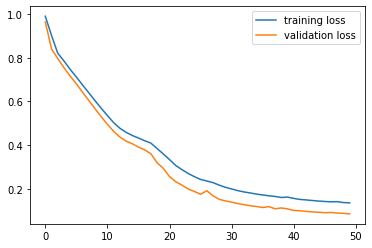

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
temp_train = [train_generator[i] for i in tqdm(range(50))]
train_dataset = np.vstack([data[0] for data in temp_train])
train_dataset.shape

bunch_sorted_index: [0 2 1]
group_bunches: [1286. 3375. 2029.]
group_bunches sorted: [1286. 2029. 3375.]
restore_index: [0 2 1]
group_bunches restored: [1286. 3375. 2029.]



(396800, 2048, 2)

In [13]:
train_dataset_meta = pd.concat([meta[1] for meta in temp_train])
train_dataset_meta.shape

(396800, 12)

In [14]:
del temp_train

In [15]:
temp_validation = [validation_generator[i] for i in tqdm(range(5))]
validation_dataset = np.vstack([data[0] for data in temp_validation])
validation_dataset.shape

(39680, 2048, 2)

In [16]:
validation_dataset_meta = pd.concat([meta[1] for meta in temp_validation])
validation_dataset_meta.shape

(39680, 12)

In [17]:
del temp_validation

# Predictions

In [18]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 62s 1s/step


(396800, 2048, 2)

In [19]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 1s/step


(39680, 2048, 2)

In [20]:
MAE_train = abs(train_pred - train_dataset).mean(axis=(1, 2)).squeeze()
MAE_train.shape

(396800,)

In [21]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=(1, 2)).squeeze()
MAE_validation.shape

(39680,)

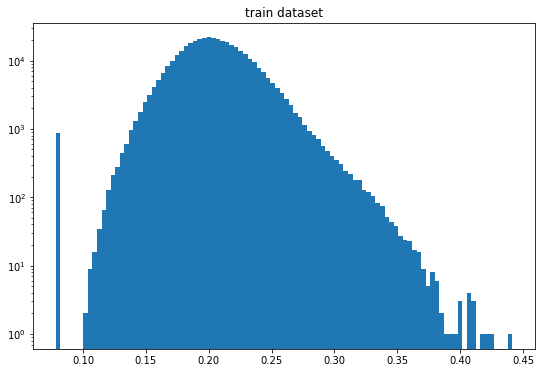

In [22]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [23]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.19822381369771674

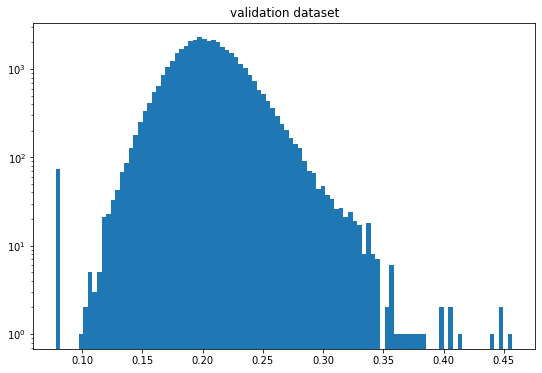

In [24]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [25]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.19574992524542956

In [26]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [27]:
max_MAE_indices

array([ 92810, 138914, 362849, ..., 337444, 359127, 347725])

In [28]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal[:, 0])
    axes[0].plot(pred_signal[:, 0])

    axes[1].plot(true_signal[:, 1])
    axes[1].plot(pred_signal[:, 1])
#     axes[1].plot(np.abs(np.diff(true_signal)))
#     axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

from pathlib import Path
from pyobsbox.utils import H5_PLANE_KEY
from pyobsbox import DB
import h5py

db = DB()

def load_plot(filepath: str, bunch_index: int):
    
    file_data = db._extract_columns(filepath)
    beam_key = "B{}".format(file_data["beam"])
    plane_key = H5_PLANE_KEY[file_data["plane"]]
    with h5py.File(filepath, "r") as h5_file:
        ob_data = h5_file[beam_key][plane_key]
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(ob_data[:, bunch_index])

index:  92810
MAE:  0.44158606141646845
n_bunches       156
bunch_index     956
bunch_number     61
chunk            17
Name: 4480, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7382/instability_data/07382_Inst_B1H_Q7_20181029_01h54m15s.h5


(32768.0, 38912.0)

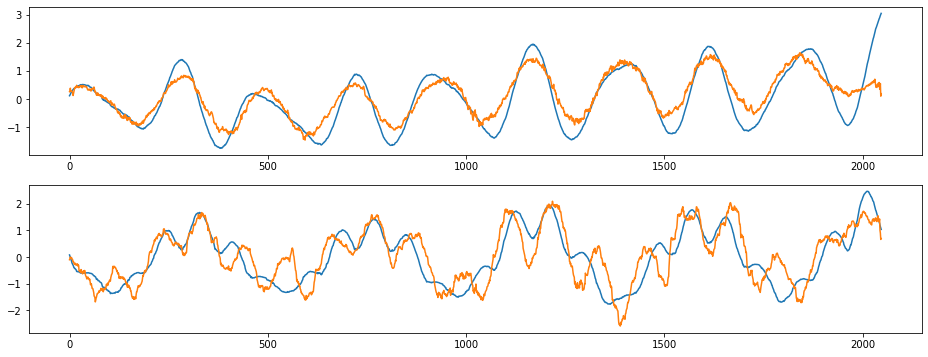

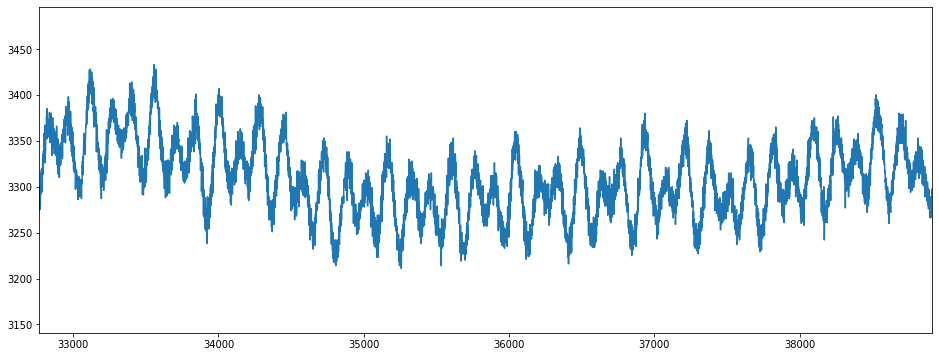

In [29]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_dataset_meta.iloc[anomalous_index]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal)
load_plot(metadata_row['file'], metadata_row['bunch_index'])

signal_chunk = metadata_row['chunk']
plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])

# Top rightmost signals

index:  92810
MAE:  0.44158606141646845
n_bunches       156
bunch_index     956
bunch_number     61
chunk            17
Name: 4480, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7382/instability_data/07382_Inst_B1H_Q7_20181029_01h54m15s.h5


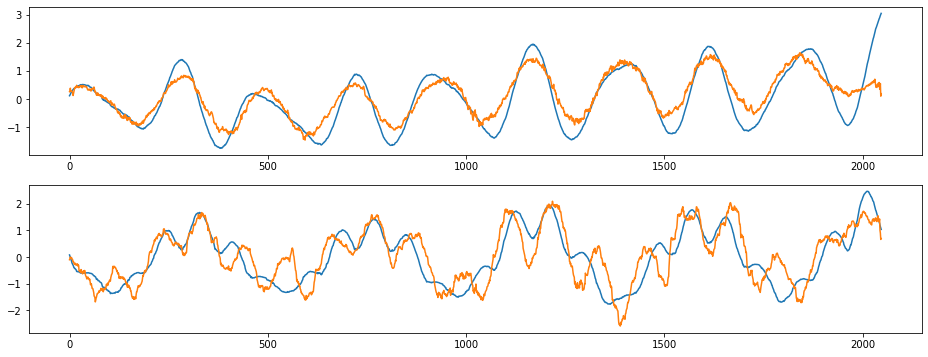

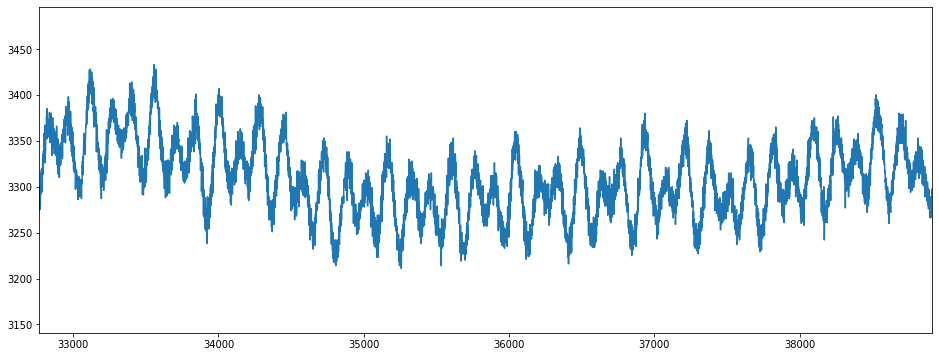

index:  138914
MAE:  0.42415479156201763
n_bunches       157
bunch_index      74
bunch_number      4
chunk            23
Name: 6066, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7362/instability_data/07362_Inst_B1H_Q7_20181026_16h16m07s.h5


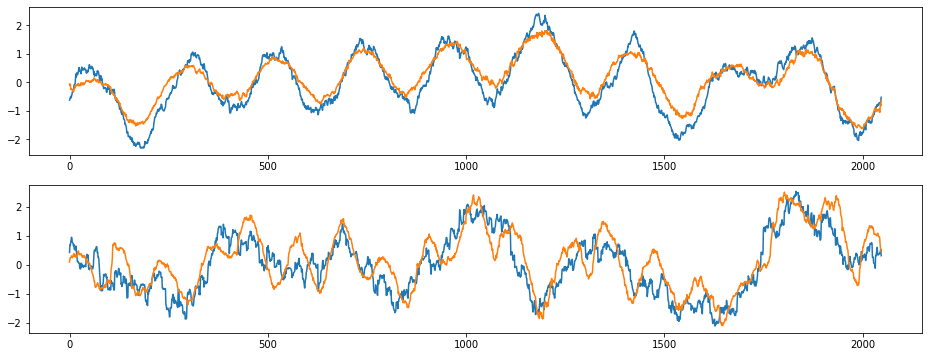

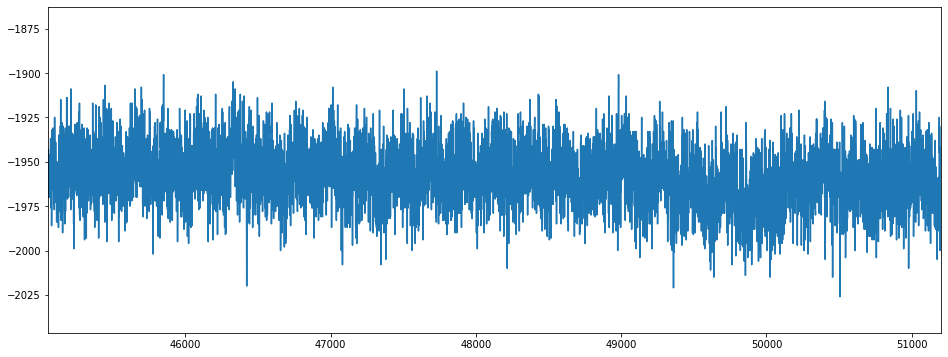

index:  362849
MAE:  0.42305021034517787
n_bunches       252
bunch_index      89
bunch_number     21
chunk            13
Name: 3382, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6738/instability_data/06738_Inst_B1H_Q7_20180529_00h04m16s.h5


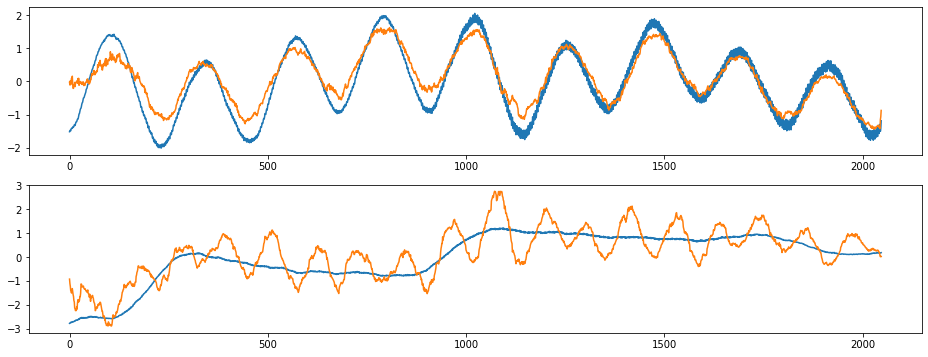

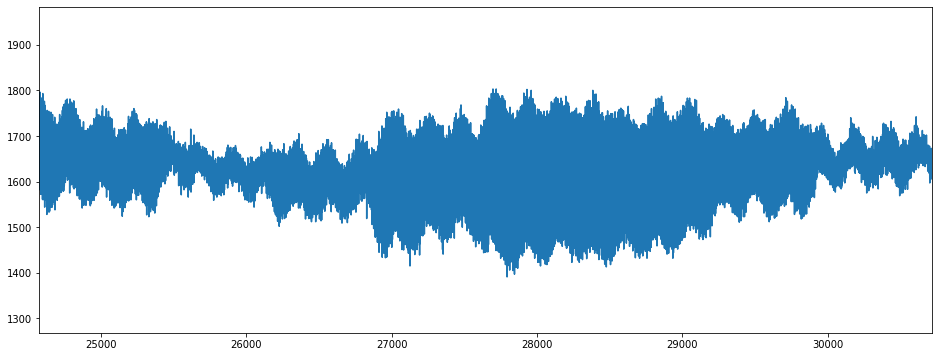

index:  91871
MAE:  0.4182068658666097
n_bunches       156
bunch_index     956
bunch_number     61
chunk             0
Name: 128, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7382/instability_data/07382_Inst_B1H_Q7_20181029_01h54m15s.h5


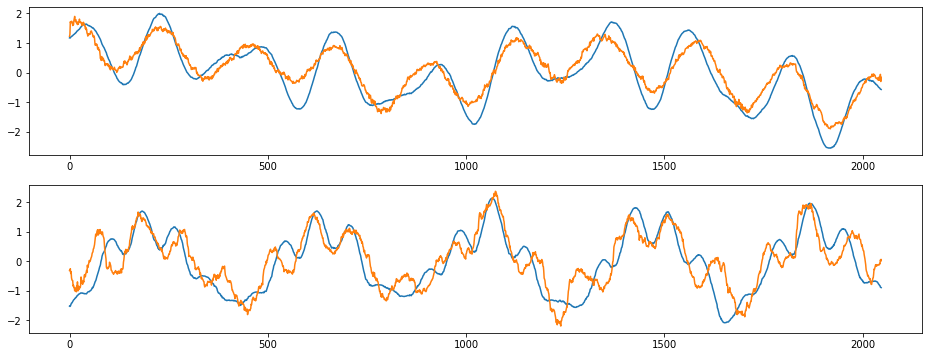

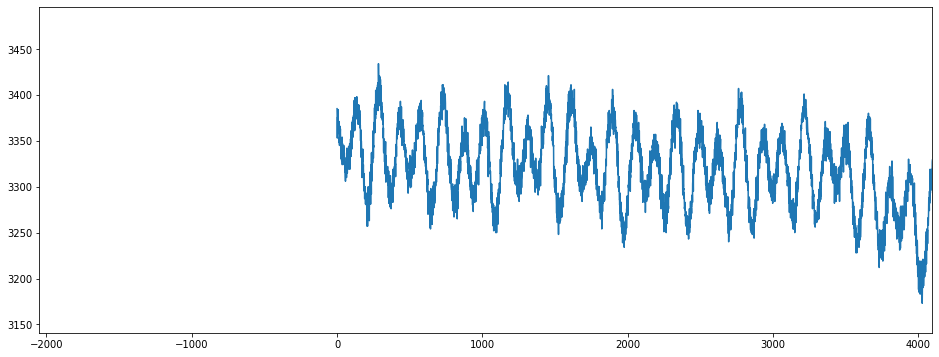

index:  249444
MAE:  0.4108665879982354
n_bunches       180
bunch_index     622
bunch_number      8
chunk             1
Name: 316, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7361/instability_data/07361_Inst_B1H_Q7_20181026_15h08m51s.h5


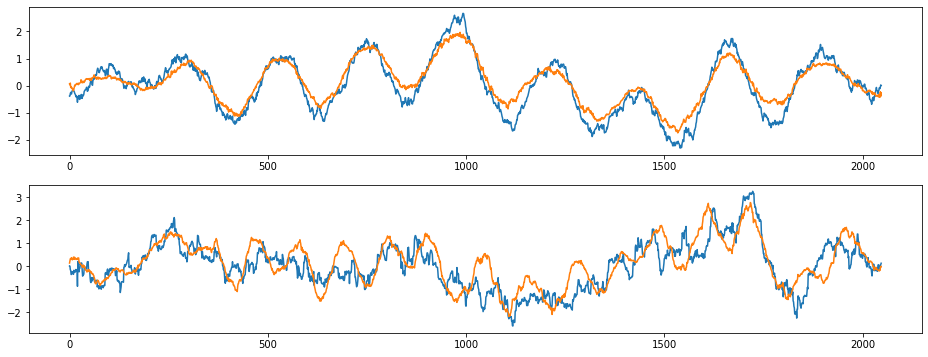

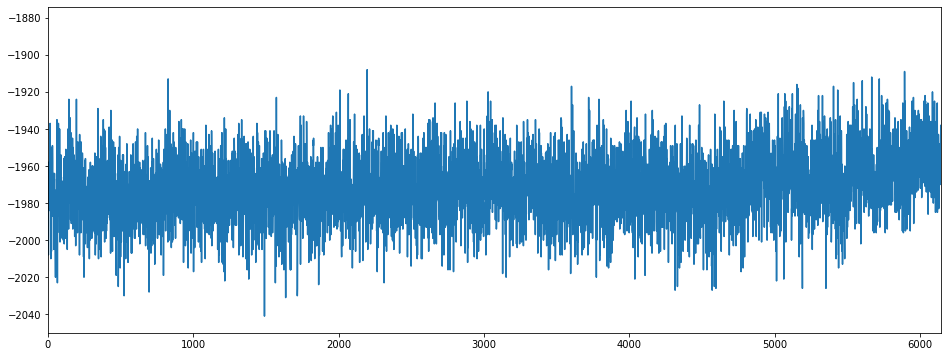

index:  25004
MAE:  0.41047139473767064
n_bunches         37
bunch_index     1206
bunch_number      19
chunk             30
Name: 7751, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7357/instability_data/07357_Inst_B1H_Q7_20181026_02h23m40s.h5


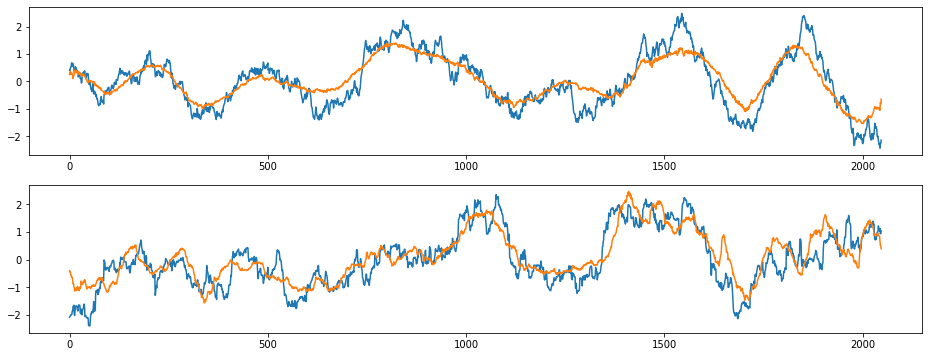

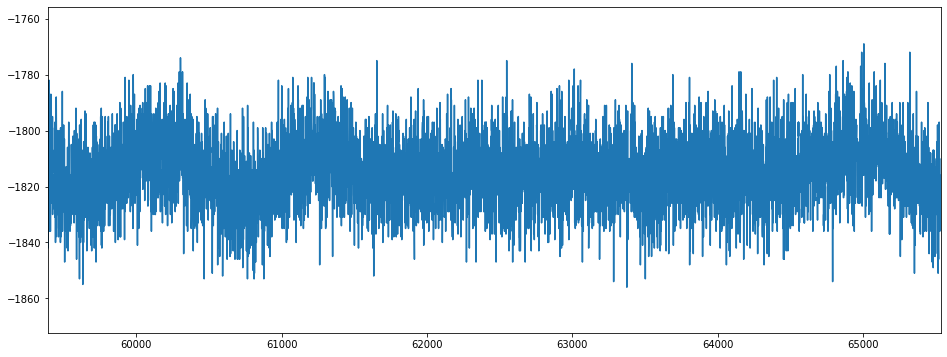

index:  320824
MAE:  0.4091375450767615
n_bunches       157
bunch_index     360
bunch_number    121
chunk            26
Name: 6830, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7362/instability_data/07362_Inst_B1H_Q7_20181026_16h21m39s.h5


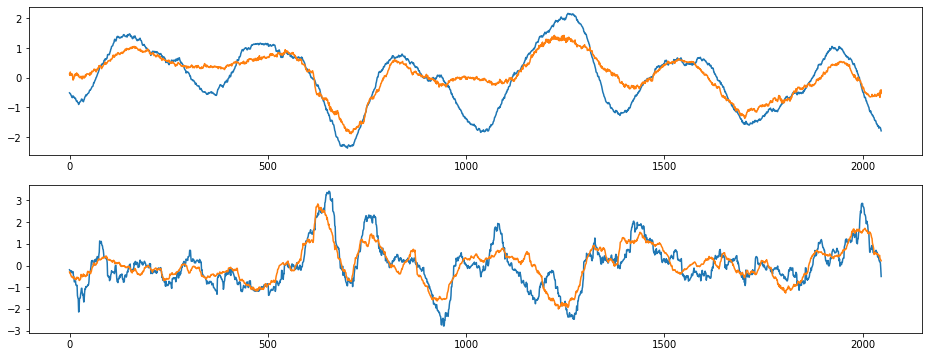

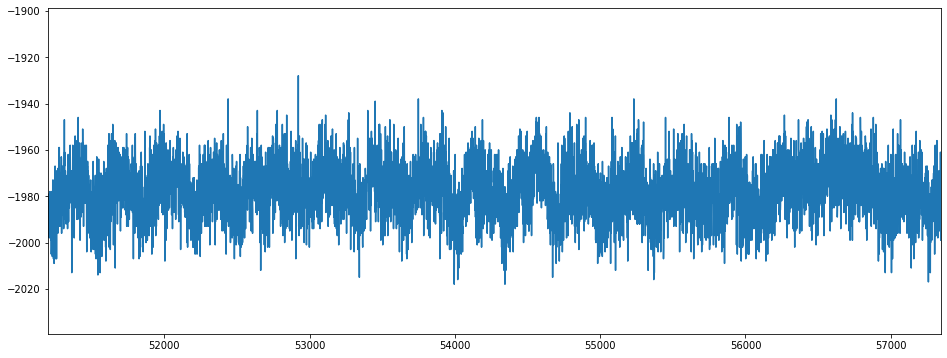

index:  376004
MAE:  0.407687367221793
n_bunches       852
bunch_index     214
bunch_number     81
chunk            14
Name: 3765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7365/instability_data/07365_Inst_B1H_Q7_20181026_23h14m19s.h5


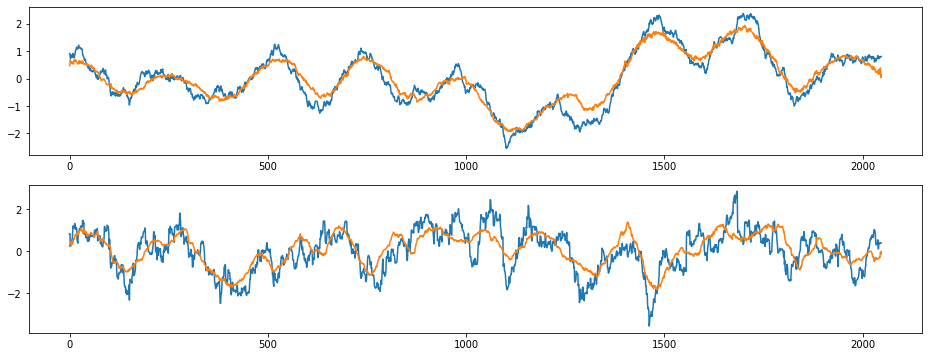

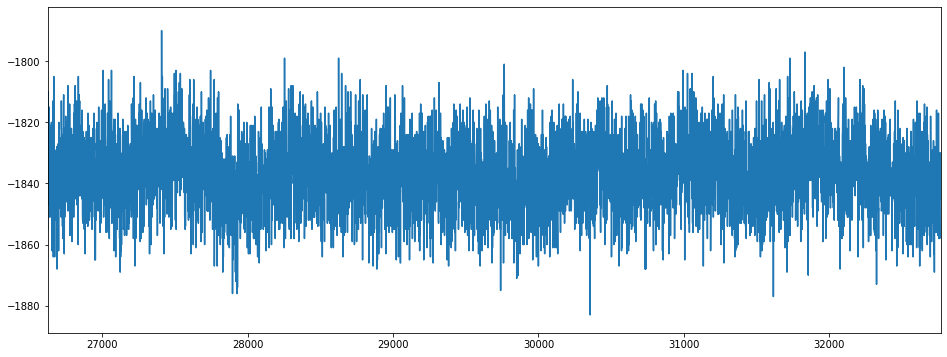

index:  143663
MAE:  0.40768160601159453
n_bunches        72
bunch_index     168
bunch_number     61
chunk            10
Name: 2810, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6615/instability_data/06615_Inst_B1H_Q7_20180426_18h27m55s.h5


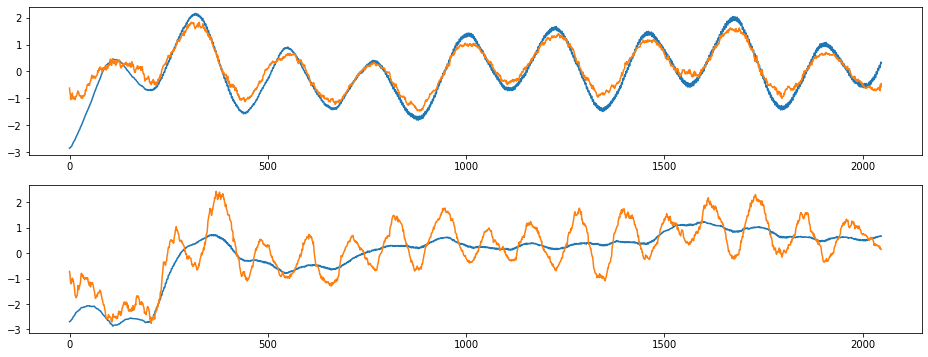

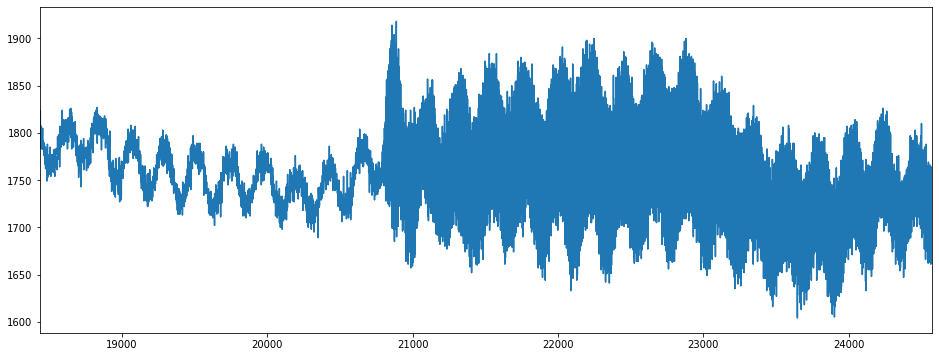

index:  153403
MAE:  0.4065244731450449
n_bunches       252
bunch_index     179
bunch_number    104
chunk            13
Name: 3356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6738/instability_data/06738_Inst_B1H_Q7_20180529_00h04m16s.h5


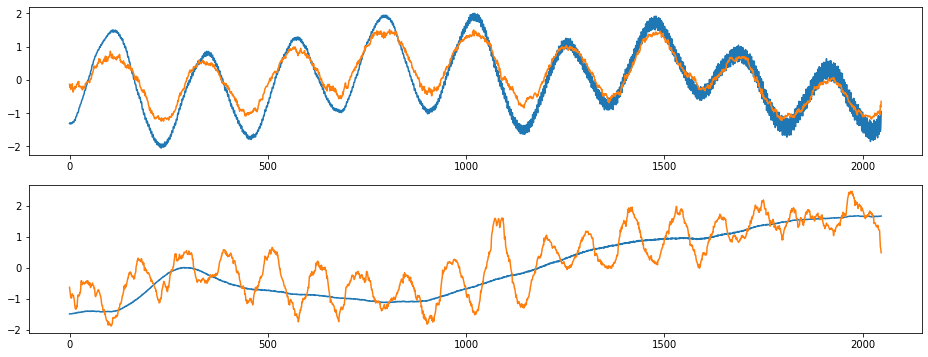

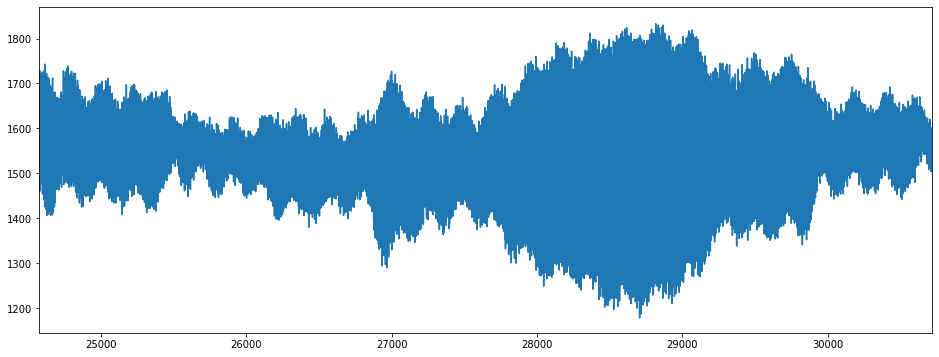

In [30]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Top leftmost signals

index:  347725
MAE:  0.0783588260153465
n_bunches        923
bunch_index     1153
bunch_number     842
chunk              2
Name: 617, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170916_23h28m00s.h5


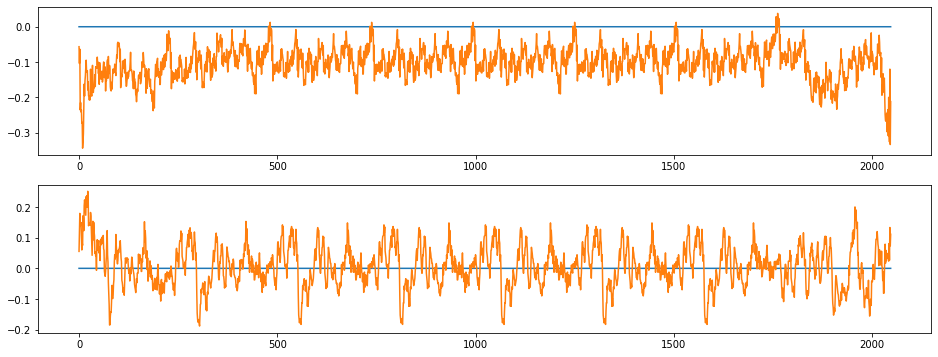

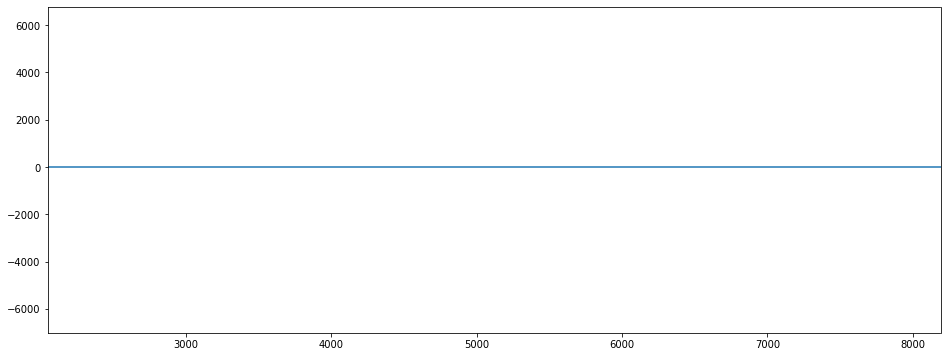

index:  359127
MAE:  0.0783588260153465
n_bunches        652
bunch_index     1105
bunch_number     589
chunk              3
Name: 787, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6411/instability_data/06411_Inst_B1H_Q7_20171122_21h34m58s.h5


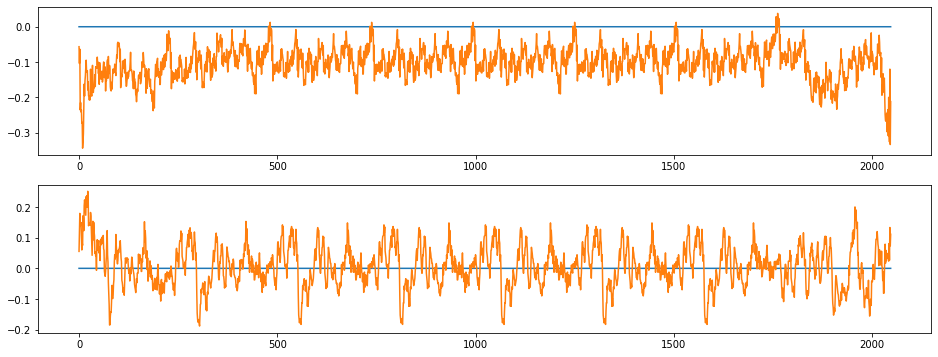

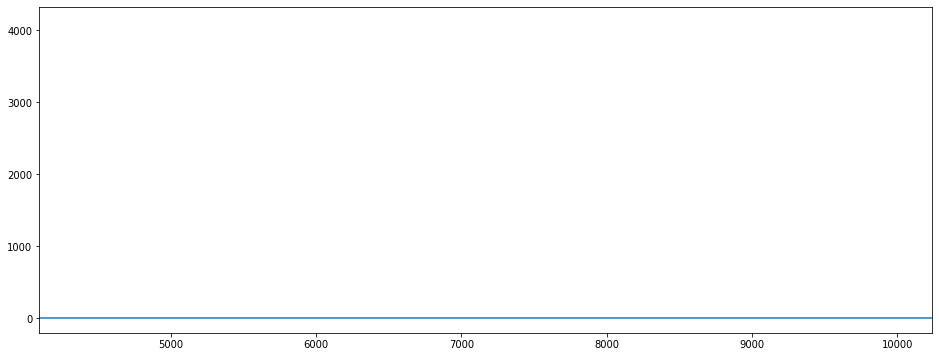

index:  337444
MAE:  0.0783588260153465
n_bunches        372
bunch_index     1963
bunch_number     367
chunk              4
Name: 1108, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_01h24m30s.h5


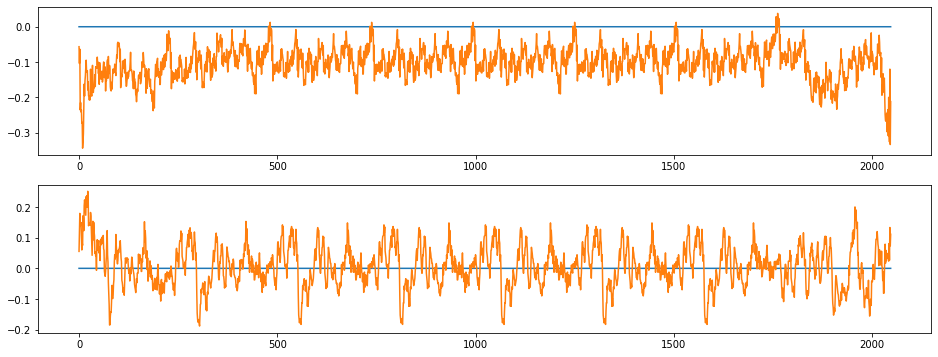

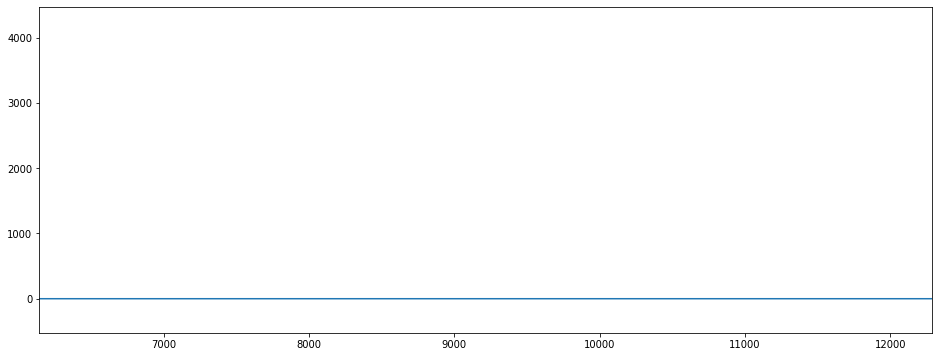

index:  374129
MAE:  0.0783588260153465
n_bunches        780
bunch_index     1800
bunch_number     766
chunk              0
Name: 110, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6399/instability_data/06399_Inst_B1H_Q7_20171120_12h32m41s.h5


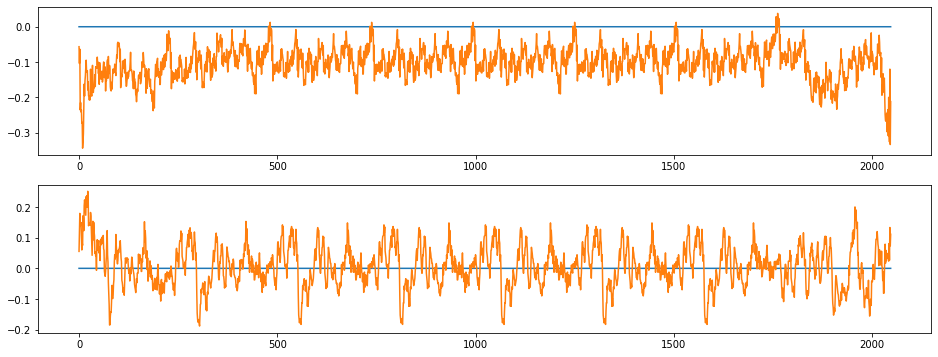

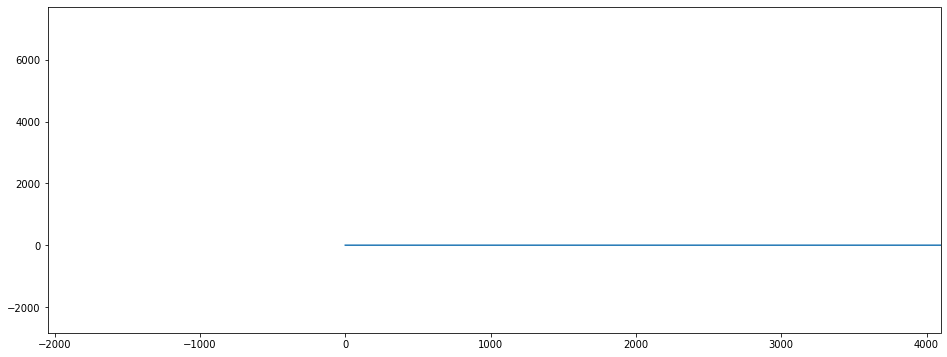

index:  244680
MAE:  0.0783588260153465
n_bunches       108
bunch_index       9
bunch_number      9
chunk            23
Name: 6011, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7314/instability_data/07314_Inst_B1H_Q7_20181017_23h05m11s.h5


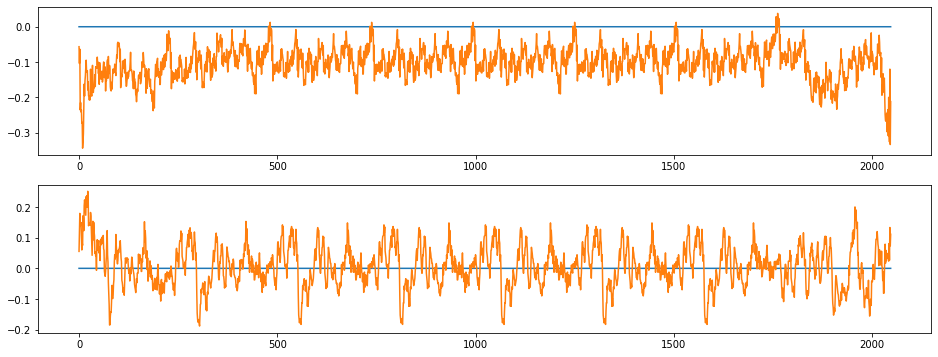

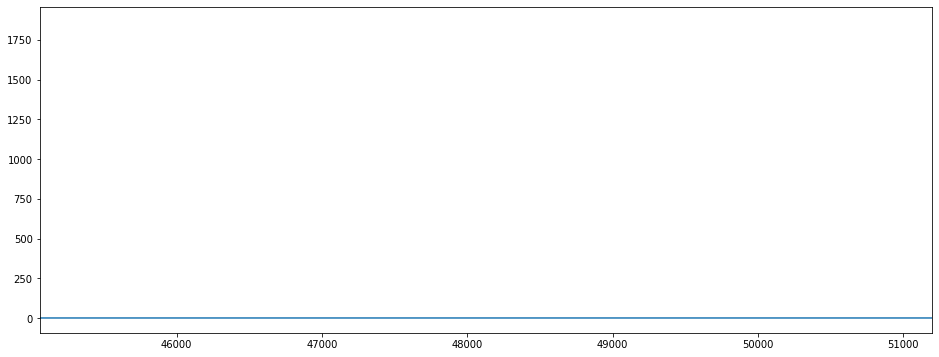

index:  240503
MAE:  0.0783588260153465
n_bunches       156
bunch_index     918
bunch_number     30
chunk             1
Name: 274, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7381/instability_data/07381_Inst_B1H_Q7_20181029_01h25m40s.h5


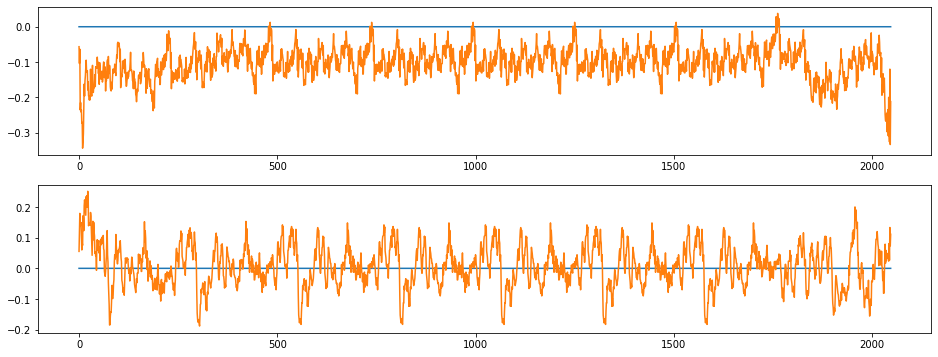

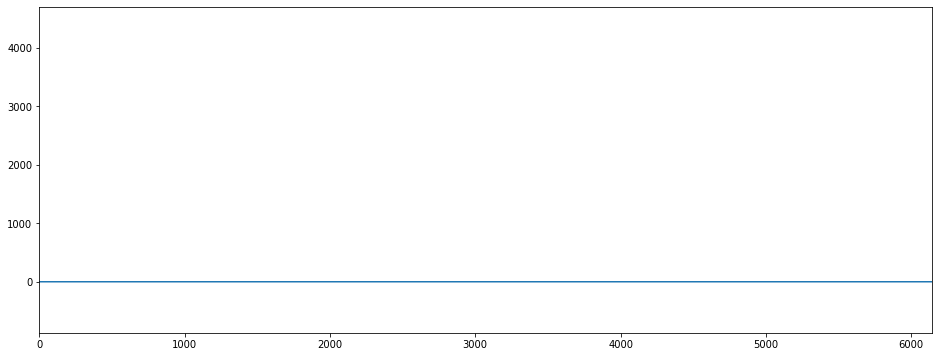

index:  222054
MAE:  0.0783588260153465
n_bunches       200
bunch_index       7
bunch_number      7
chunk            25
Name: 6409, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6214/instability_data/06214_Inst_B1H_Q7_20170916_19h32m14s.h5


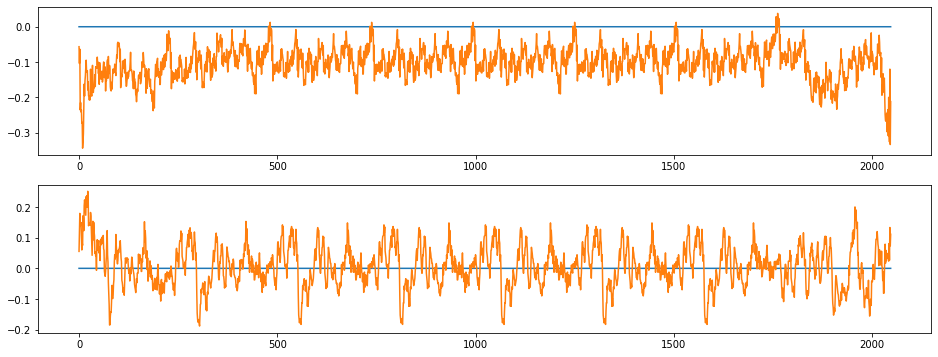

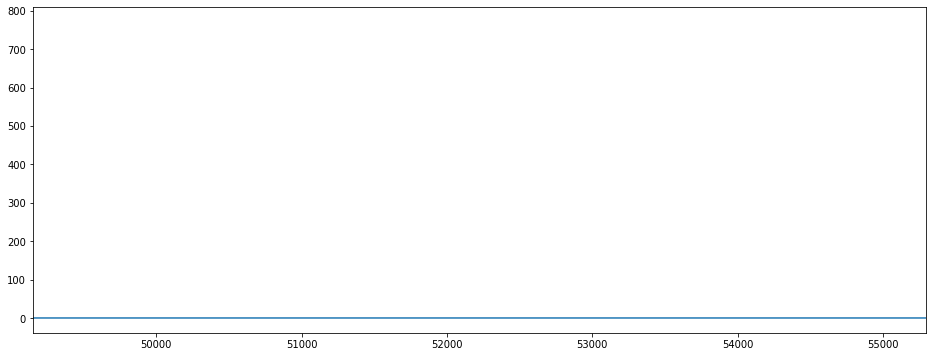

index:  189861
MAE:  0.0783588260153465
n_bunches        780
bunch_index     1268
bunch_number     678
chunk              3
Name: 1020, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6351/instability_data/06351_Inst_B1H_Q7_20171031_15h16m08s.h5


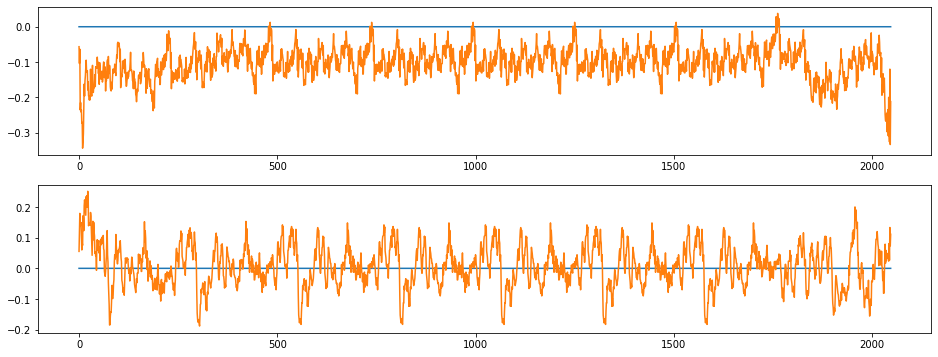

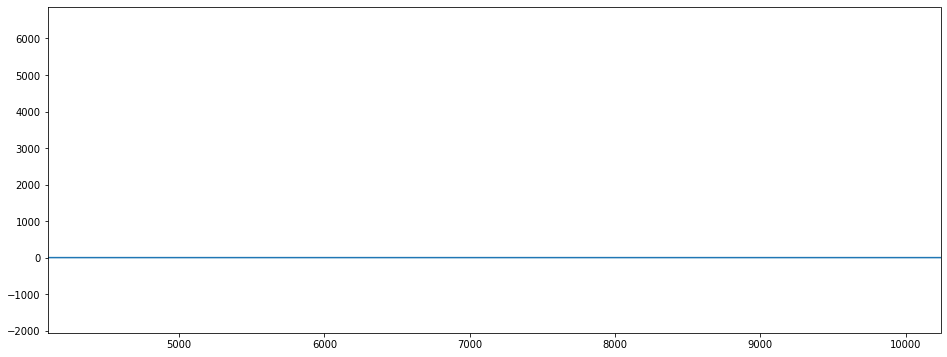

index:  337340
MAE:  0.0783588260153465
n_bunches        372
bunch_index     1963
bunch_number     367
chunk              2
Name: 596, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_01h24m30s.h5


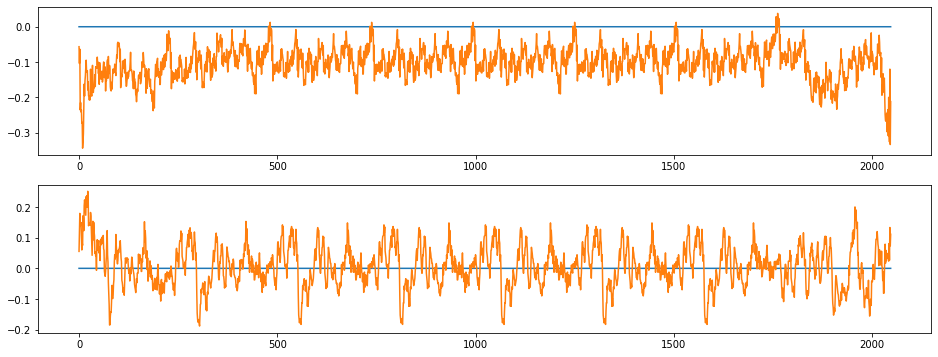

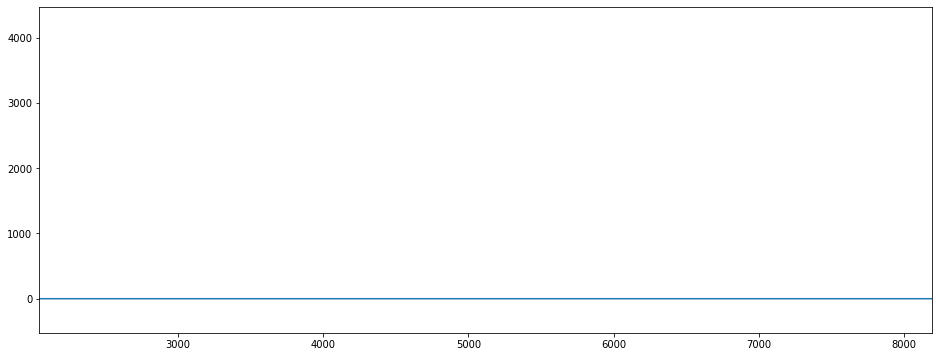

index:  255858
MAE:  0.0783588260153465
n_bunches        924
bunch_index     1213
bunch_number     890
chunk              5
Name: 1518, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7045/instability_data/07045_Inst_B1H_Q7_20180811_23h21m15s.h5


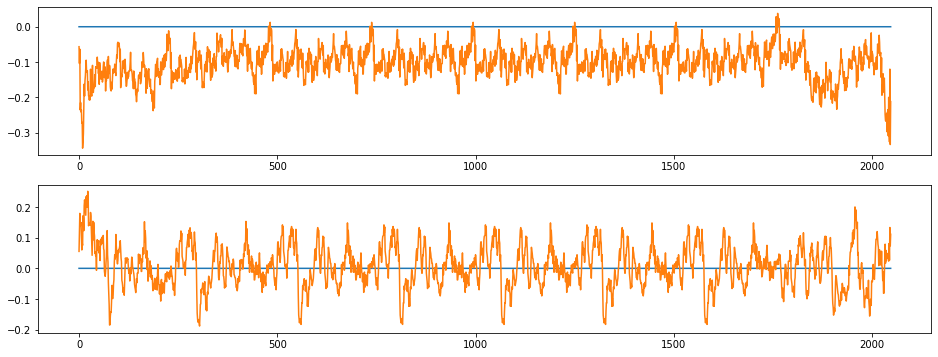

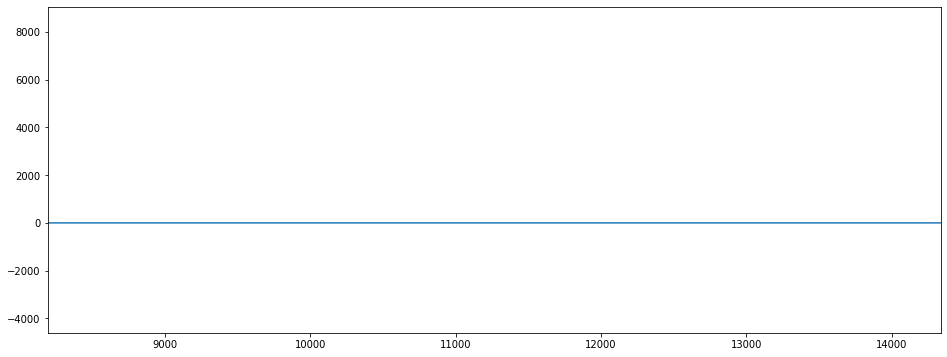

In [31]:
for i in range(1, 11):
    left_most = -i
    anomalous_index = max_MAE_indices[left_most]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Signals around the peak

In [32]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  293101
MAE:  0.19822395885449384
n_bunches        652
bunch_index     3161
bunch_number     587
chunk             13
Name: 3515, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6429/instability_data/06429_Inst_B1H_Q7_20171128_05h15m50s.h5


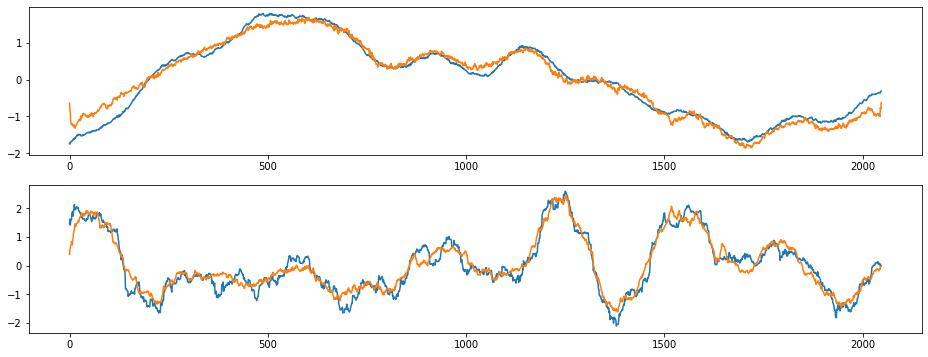

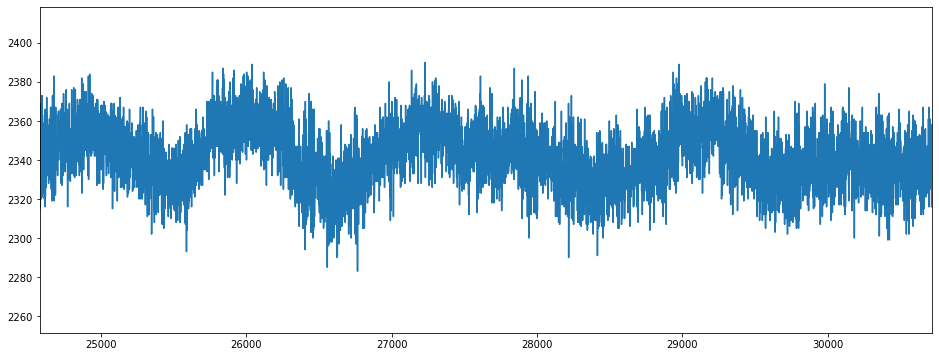

index:  235892
MAE:  0.19822398924735918
n_bunches       2556
bunch_index     1113
bunch_number     804
chunk             30
Name: 7839, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7139/instability_data/07139_Inst_B1H_Q7_20180908_19h17m52s.h5


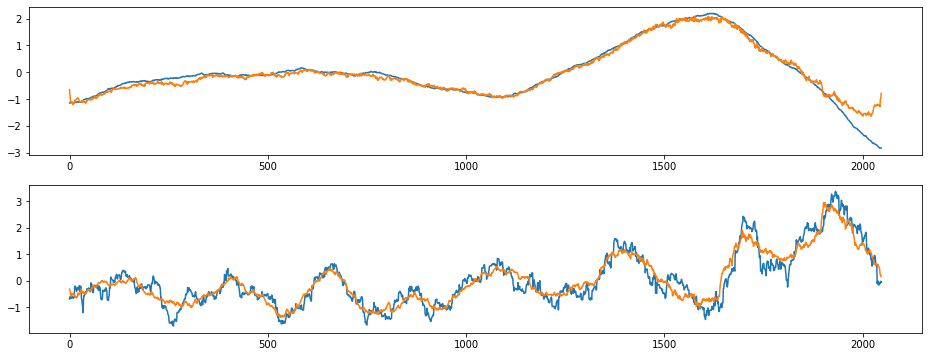

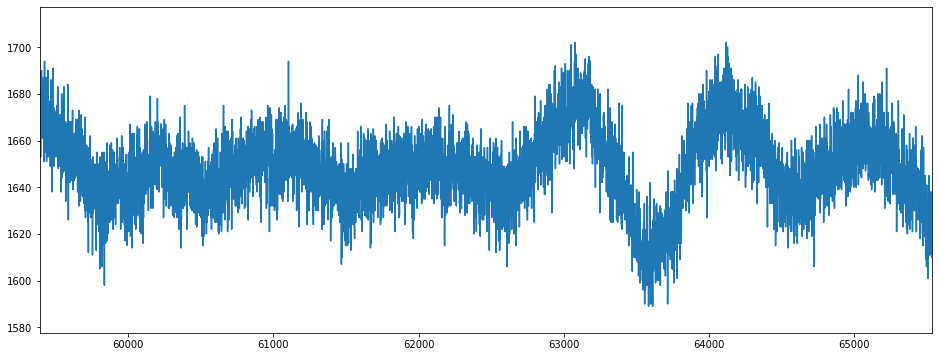

index:  374791
MAE:  0.19822361518878262
n_bunches        82
bunch_index     273
bunch_number     54
chunk            24
Name: 6354, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7480/instability_data/07480_Inst_B1H_Q7_20181127_22h36m46s.h5


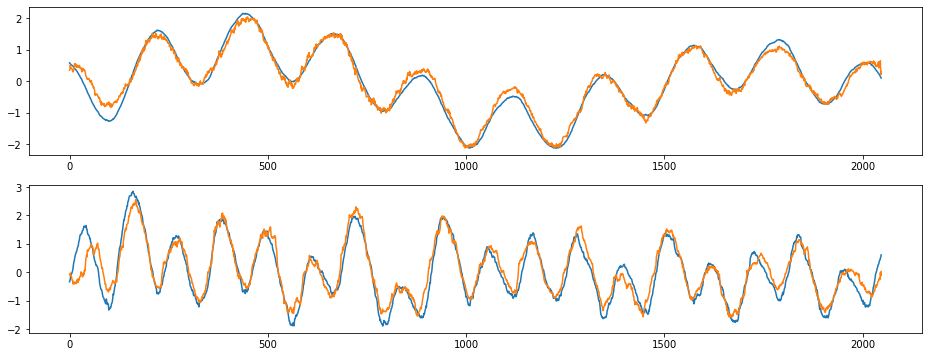

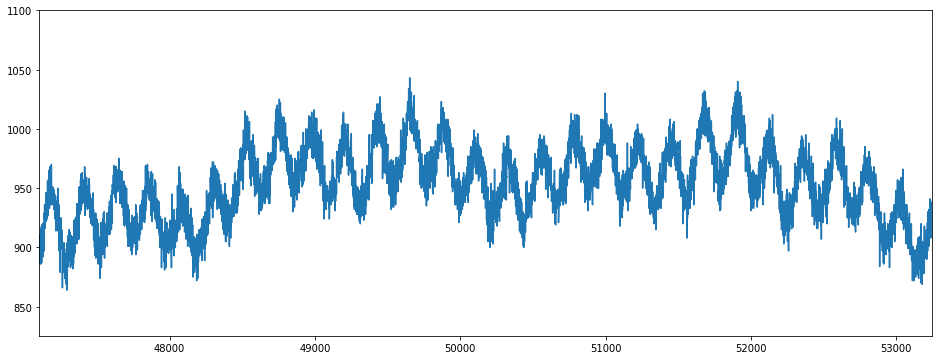

index:  346103
MAE:  0.19822360383440496
n_bunches       554
bunch_index      62
bunch_number     23
chunk            13
Name: 3497, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/instability_data/06616_Inst_B1H_Q7_20180427_03h53m14s.h5


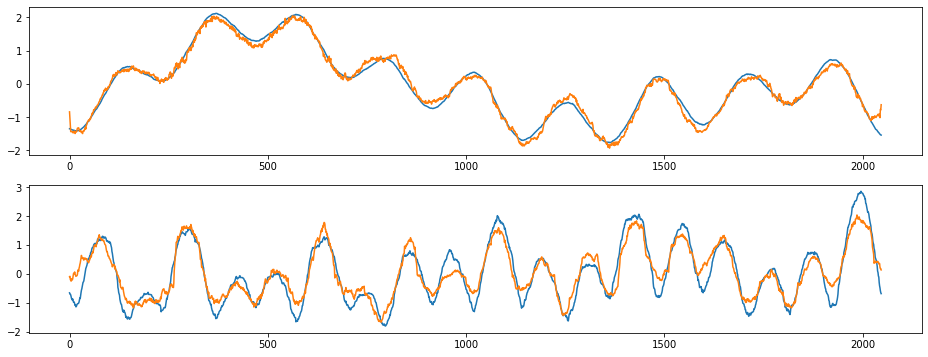

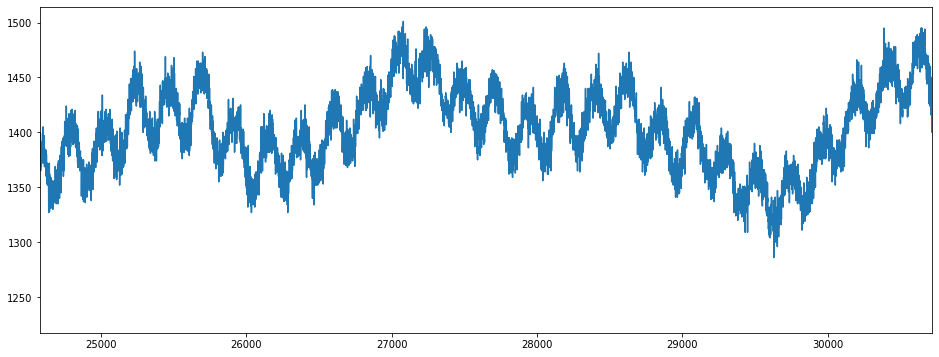

index:  117004
MAE:  0.19822403795922053
n_bunches       636
bunch_index     783
bunch_number    557
chunk            11
Name: 2862, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7256/instability_data/07256_Inst_B1H_Q7_20181004_02h42m37s.h5


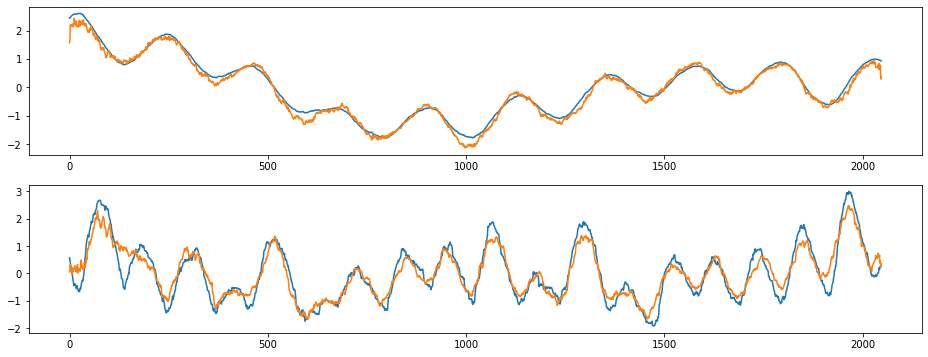

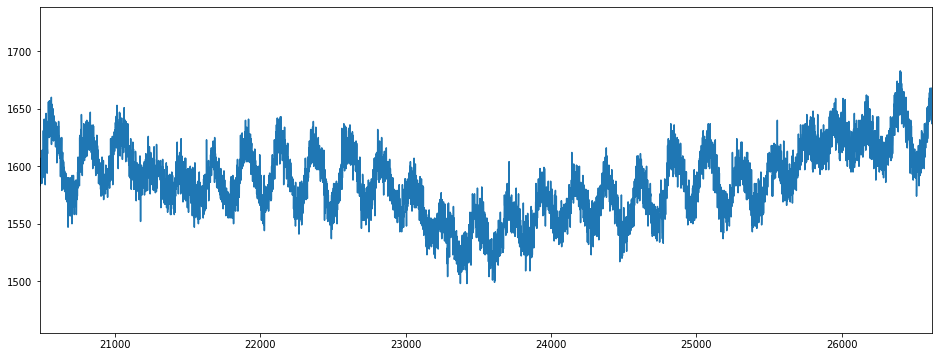

index:  144151
MAE:  0.19822358786843763
n_bunches       252
bunch_index     234
bunch_number    147
chunk            17
Name: 4373, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6936/instability_data/06936_Inst_B1H_Q7_20180717_15h04m56s.h5


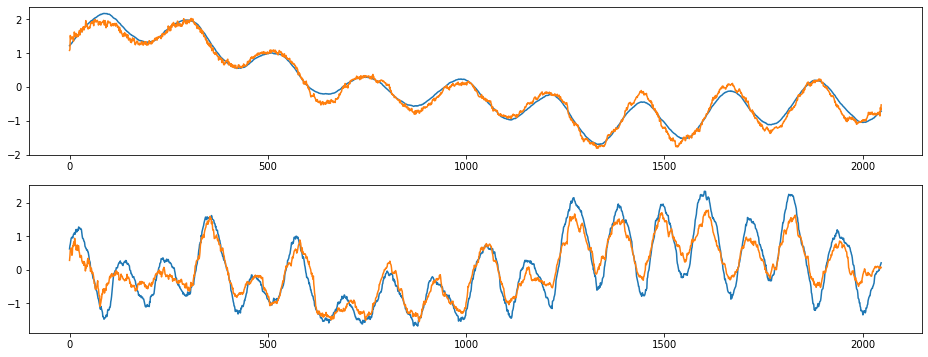

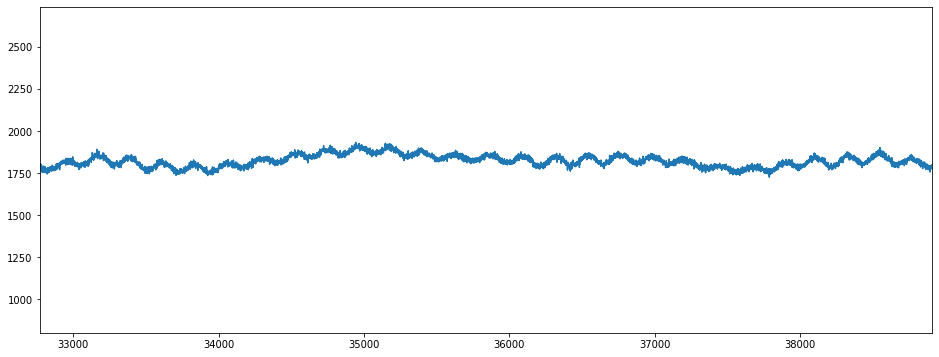

index:  190827
MAE:  0.19822358508210142
n_bunches       636
bunch_index     801
bunch_number    575
chunk             7
Name: 1837, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7270/instability_data/07270_Inst_B1H_Q7_20181008_23h58m03s.h5


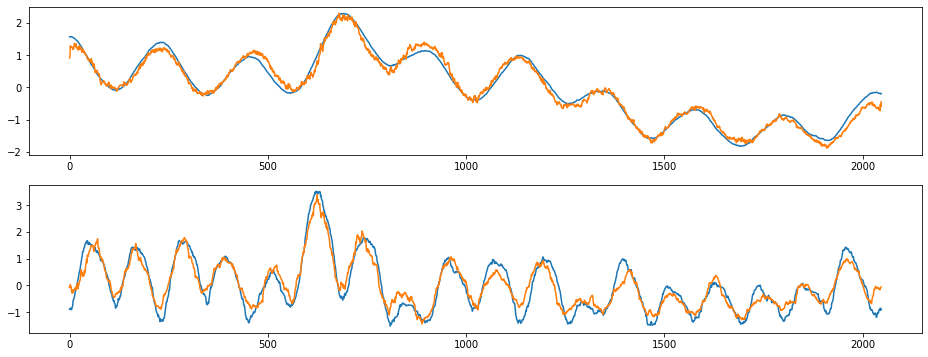

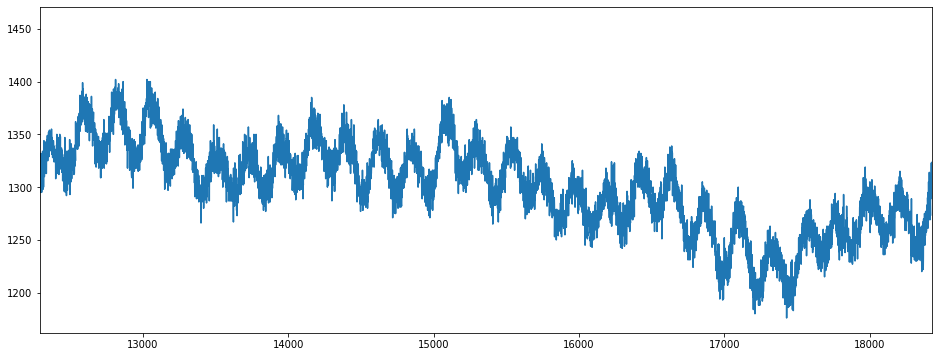

index:  142005
MAE:  0.19822405891902495
n_bunches       1116
bunch_index     1262
bunch_number     578
chunk             15
Name: 3969, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6587/instability_data/06587_Inst_B1H_Q7_20180421_16h10m14s.h5


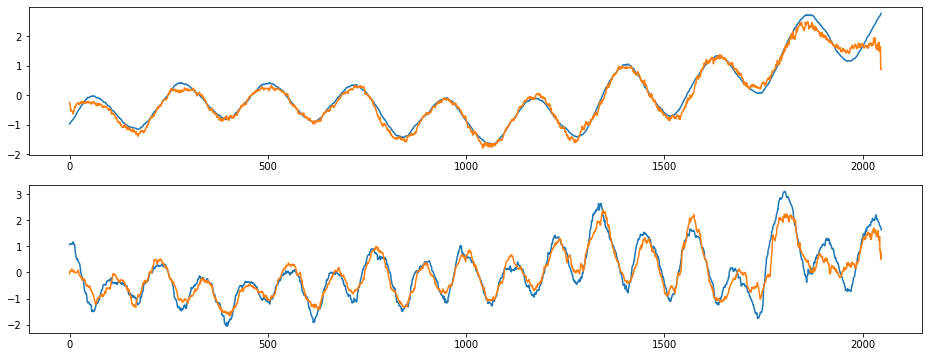

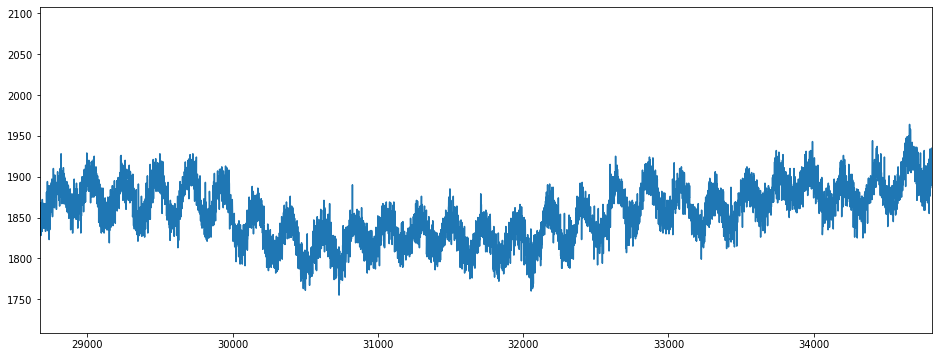

index:  126986
MAE:  0.19822348834828368
n_bunches       1166
bunch_index      345
bunch_number     193
chunk              9
Name: 2381, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_20h13m54s.h5


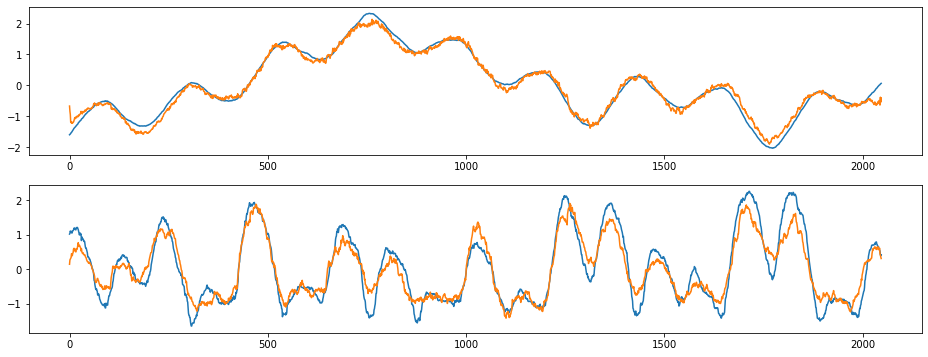

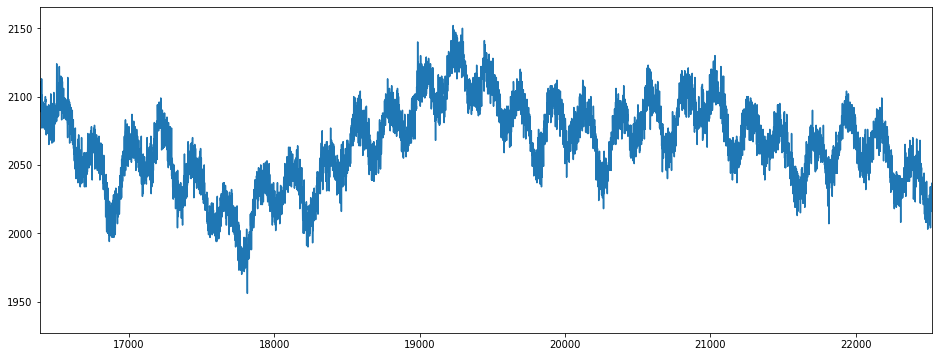

index:  41302
MAE:  0.19822419222175286
n_bunches        372
bunch_index     1751
bunch_number     326
chunk             16
Name: 4306, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7449/instability_data/07449_Inst_B1H_Q7_20181116_17h29m49s.h5


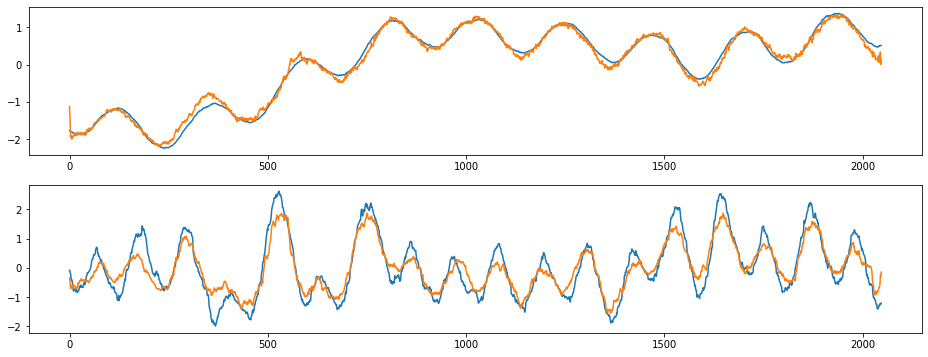

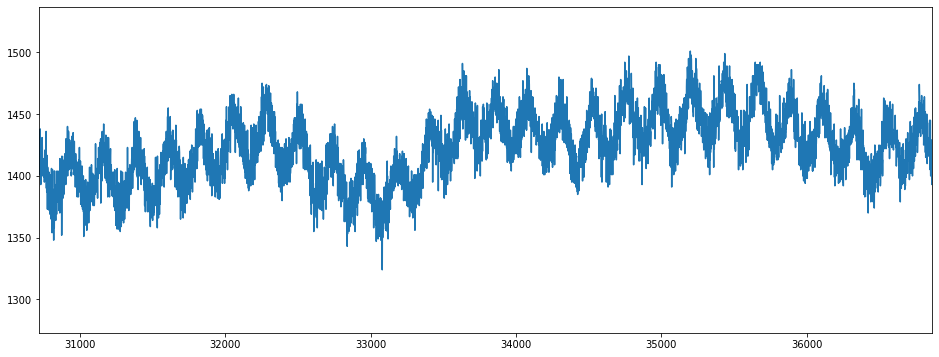

In [33]:
for i in range(10):
    anomalous_index = around_peak_indices[i]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# around a point

In [34]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.1))

index:  150506
MAE:  0.10049461834419038
n_bunches        603
bunch_index     1311
bunch_number     268
chunk              4
Name: 1255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6614/instability_data/06614_Inst_B1H_Q7_20180426_05h52m14s.h5


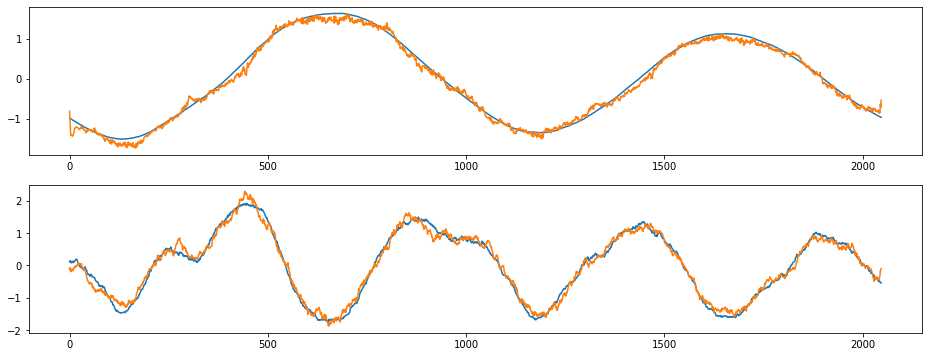

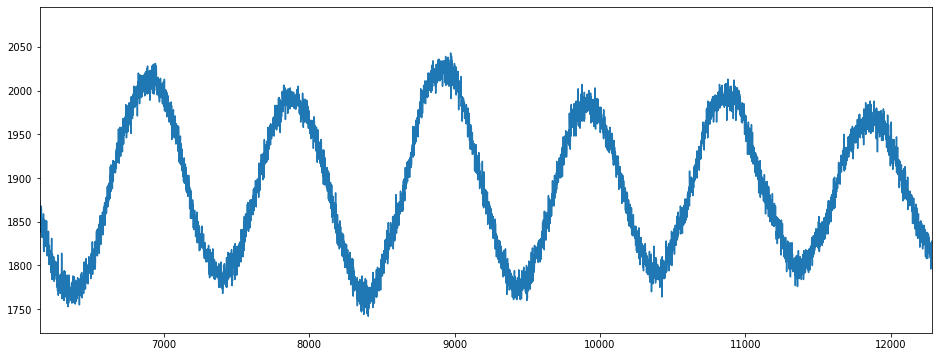

index:  206698
MAE:  0.10378019689705124
n_bunches       2556
bunch_index     2619
bunch_number    1942
chunk             28
Name: 7393, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7133/instability_data/07133_Inst_B1H_Q7_20180907_15h50m14s.h5


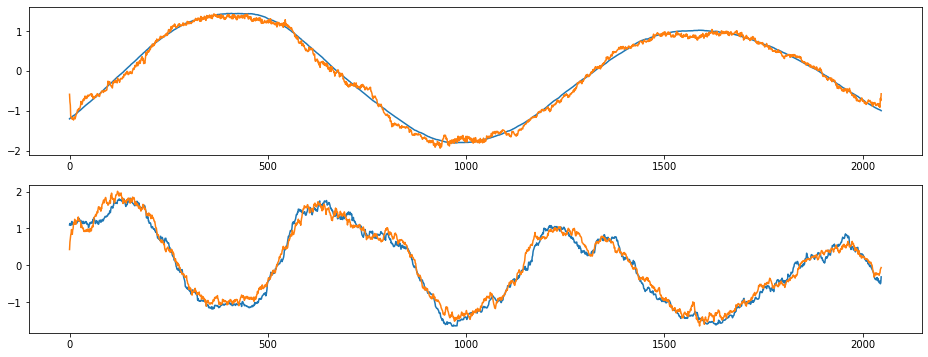

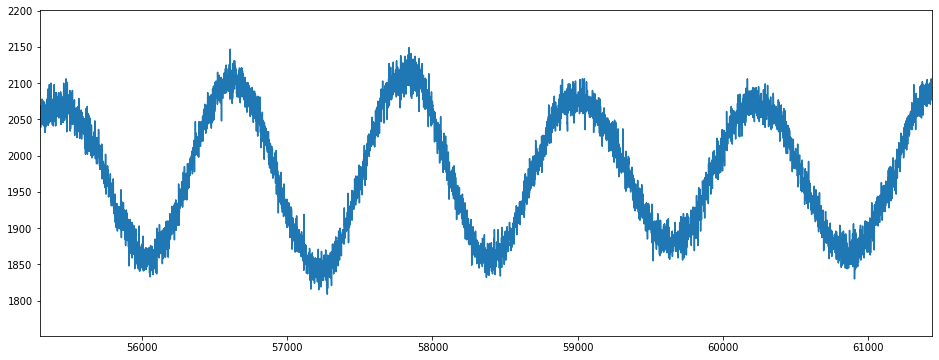

index:  221983
MAE:  0.10439579306460722
n_bunches       252
bunch_index     151
bunch_number     76
chunk             6
Name: 1753, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6705/instability_data/06705_Inst_B1H_Q7_20180520_07h01m14s.h5


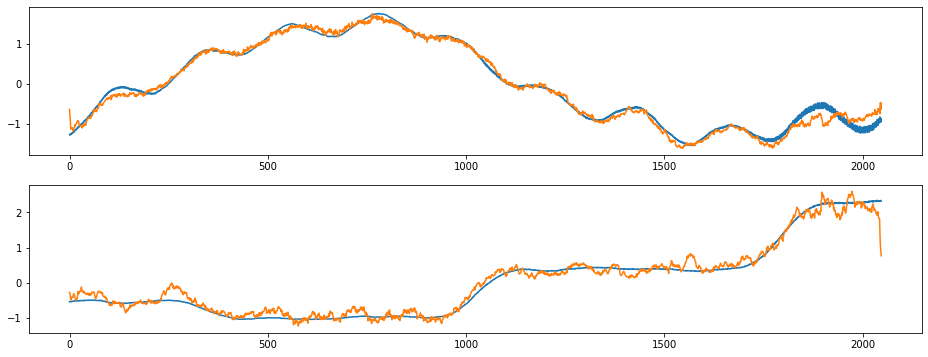

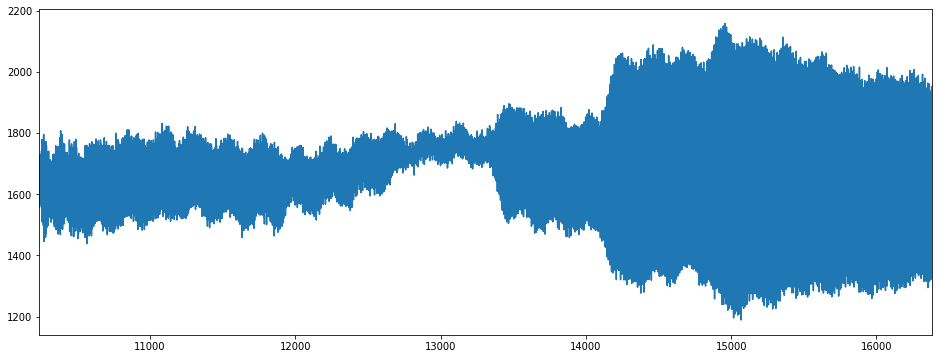

index:  31940
MAE:  0.10452938213380128
n_bunches       603
bunch_index      96
bunch_number     15
chunk            10
Name: 2643, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6612/instability_data/06612_Inst_B1H_Q7_20180425_14h29m14s.h5


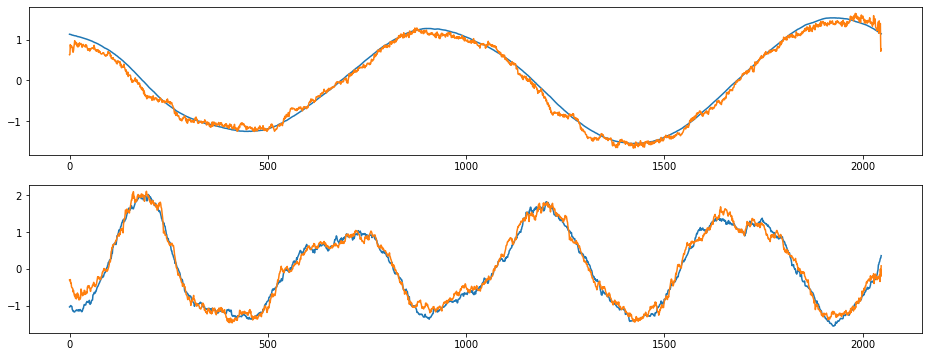

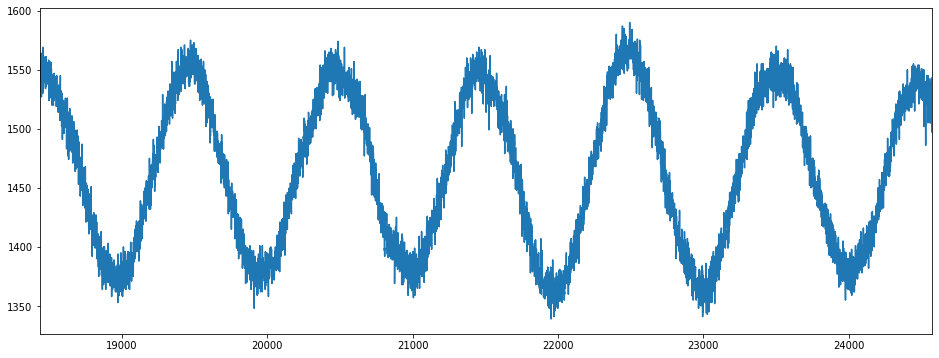

index:  338399
MAE:  0.10471108625251924
n_bunches        632
bunch_index     1742
bunch_number     320
chunk              9
Name: 2429, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7443/instability_data/07443_Inst_B1H_Q7_20181114_17h02m14s.h5


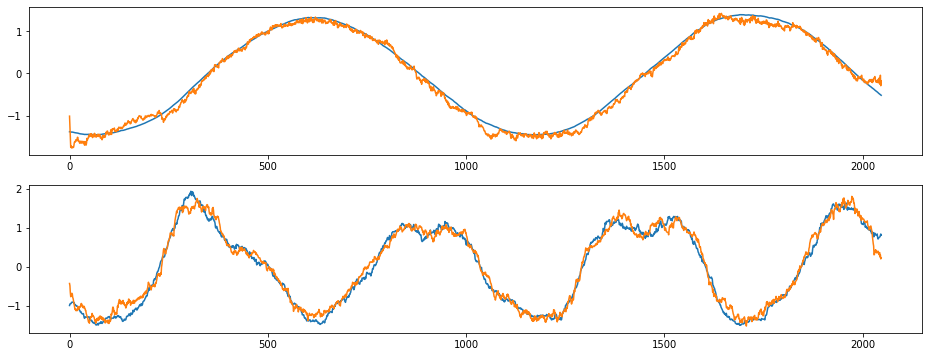

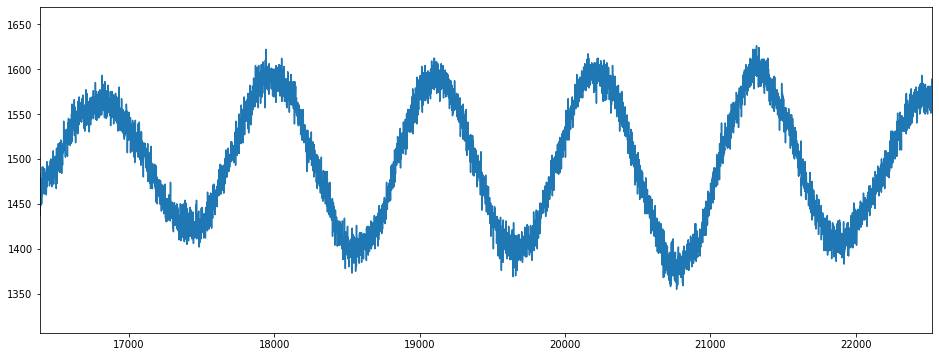

index:  147033
MAE:  0.10570376395766982
n_bunches        603
bunch_index     1311
bunch_number     268
chunk              3
Name: 999, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6614/instability_data/06614_Inst_B1H_Q7_20180426_05h52m14s.h5


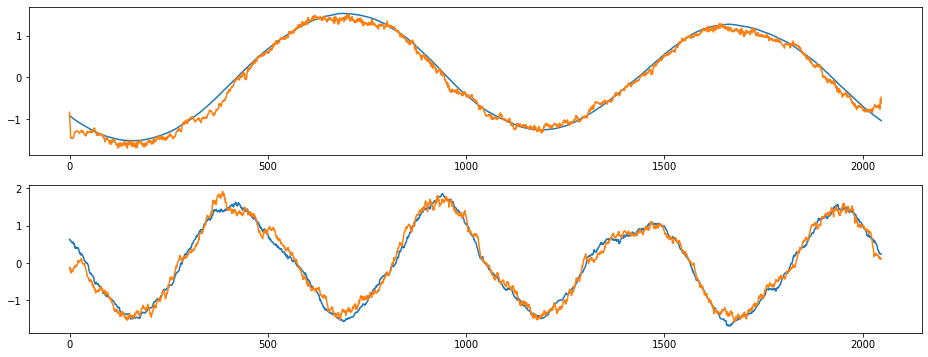

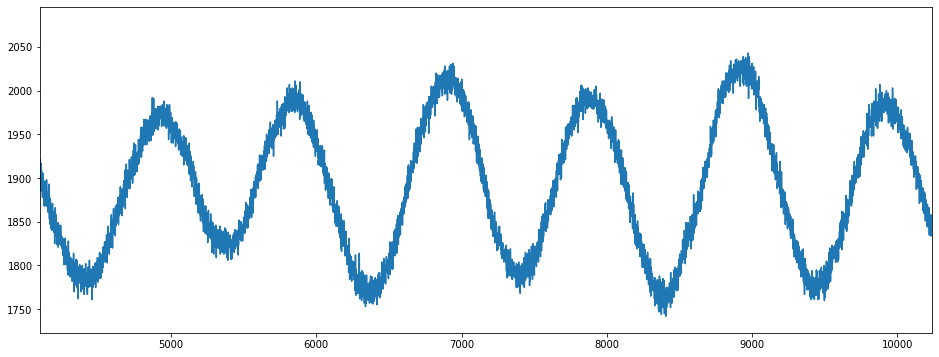

index:  284897
MAE:  0.10596190546781523
n_bunches       733
bunch_index     824
bunch_number    171
chunk            24
Name: 6247, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_20h50m15s.h5


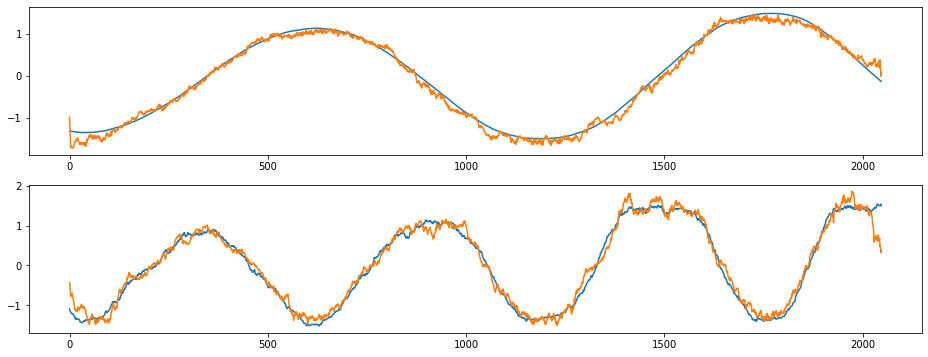

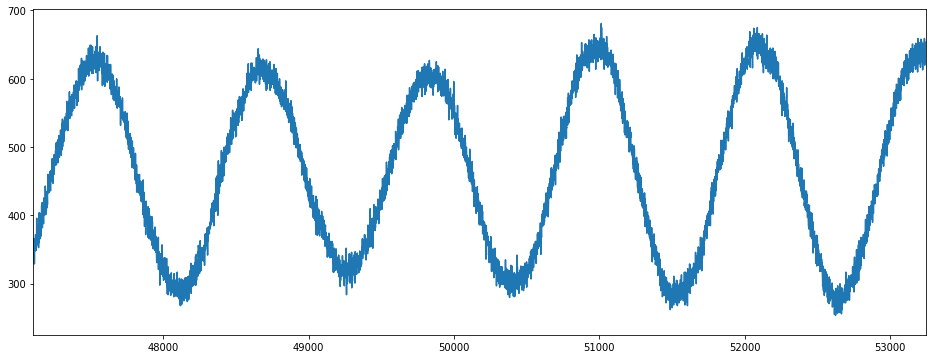

index:  125336
MAE:  0.10652347443244728
n_bunches       603
bunch_index     373
bunch_number    110
chunk            10
Name: 2599, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6612/instability_data/06612_Inst_B1H_Q7_20180425_14h29m14s.h5


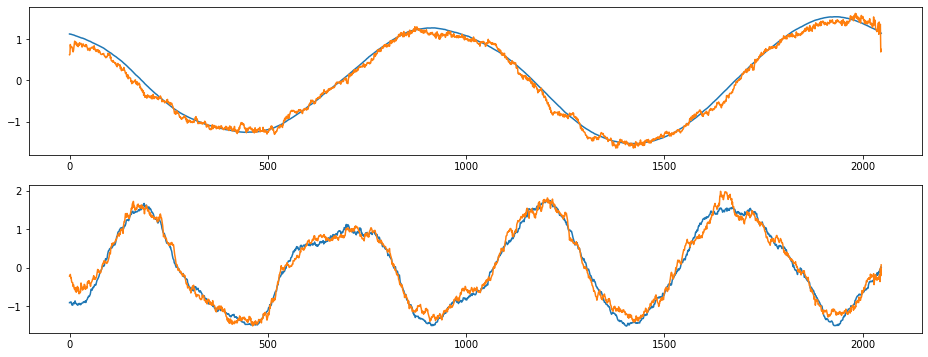

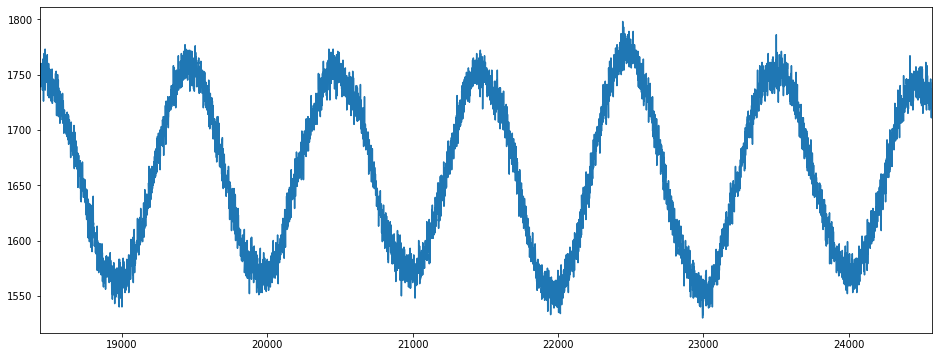

index:  207140
MAE:  0.10685290671925896
n_bunches       2556
bunch_index     2619
bunch_number    1942
chunk             24
Name: 6369, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7133/instability_data/07133_Inst_B1H_Q7_20180907_15h50m14s.h5


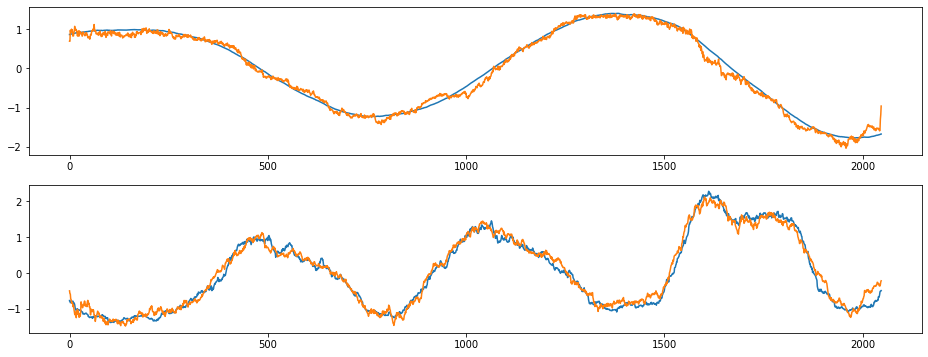

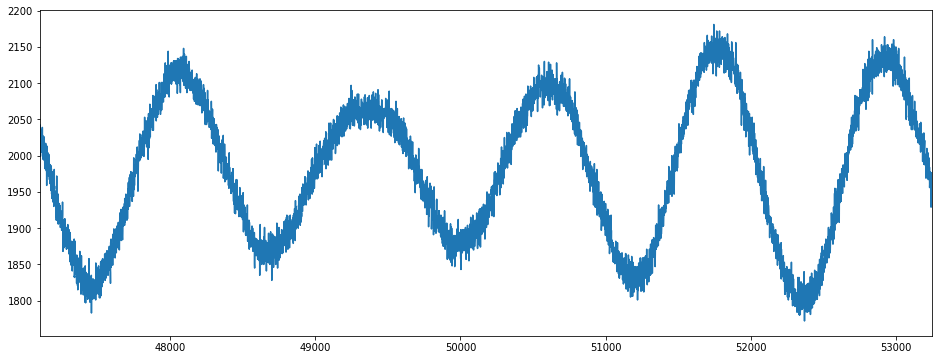

index:  354213
MAE:  0.10706484934055199
n_bunches       2556
bunch_index      620
bunch_number     424
chunk              3
Name: 814, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/instability_data/06663_Inst_B1H_Q7_20180510_15h13m15s.h5


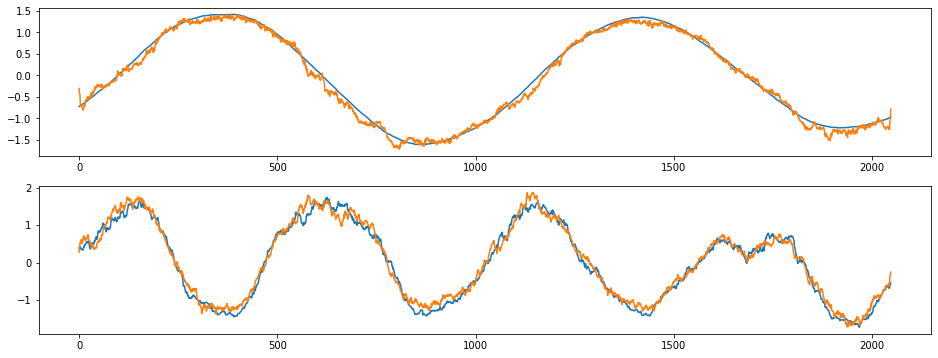

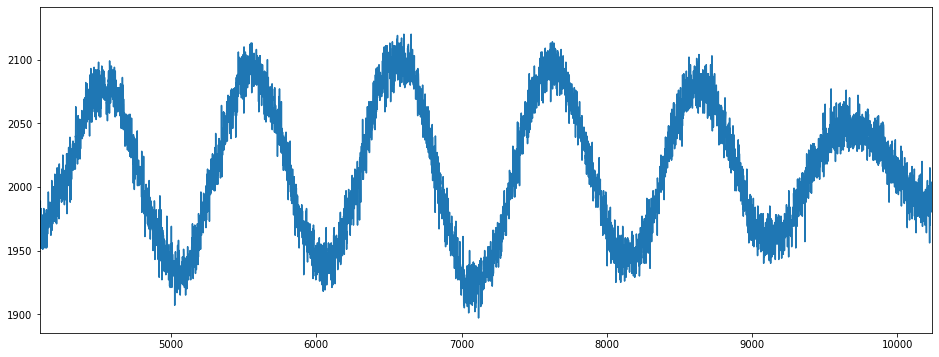

In [35]:
for i in range(10):
    index = around_point_indices[i]

    print('index: ', index)
    print("MAE: ", MAE_train[index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[index].squeeze()
    pred_signal = train_pred[index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

In [36]:
break

SyntaxError: 'break' outside loop (<ipython-input-36-6aaf1f276005>, line 4)

# latent space encoding

In [ ]:
import keras

In [ ]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [ ]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

In [ ]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

In [ ]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

In [ ]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [ ]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [ ]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [ ]:
np.save(model_latent_space_file, latent_dataset)

In [ ]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [ ]:
np.save(model_train_dataset_file, train_dataset)

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)